In [5]:
monitor='val_accuracy'
epochs=150
batch_size=32
input_shape=(224, 224, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [1]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
skimage: 0.21.0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow: 2.13.0


In [2]:
#apt-get install git python3-opencv
import os

if not os.path.isdir('k'):
  !git clone https://github.com/hamidpeywasti/keras-neural-api k
else:
  !cd k && git pull

!cd k && pip install .

!rm -rf k

import cai
import cai.datasets
import cai.models
import cai.inception_v3
import cai.layers
import cai.util
from cai.layers import conv2d_bn

Cloning into 'k'...
remote: Enumerating objects: 1809, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 1809 (delta 135), reused 147 (delta 72), pack-reused 1588
Receiving objects: 100% (1809/1809), 15.69 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (1248/1248), done.
Processing /kaggle/working/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61387 sha256=b61ad8c65384a0fe2afe2f8a29f10a0860e177892db96ca34c07e3c327522e67
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_fq327w/wheels/7f/63/1a/ed2b6234f76aae55efe76492246448486e41178bd0b5682ecf
Successfully built cai


# 2Path with 5 Conv

In [3]:
def two_path5_inception_v5(
                include_top=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(224,224,3),
                pooling=None,
                classes=1000,
                two_paths=False,
                deep_two_paths=False,
                deep_two_paths_compression=0.655,
                deep_two_paths_bottleneck_compression=0.5,
                l_ratio=0.5,
                ab_ratio=0.5,
                max_mix_idx=10,
                max_mix_deep_two_paths_idx=-1,
                model_name='two_path_inception_v3',
                kType=0,
                **kwargs):
    """
    Instantiates the Inception v3 architecture with 2 paths options.
    """
    img_input = keras.layers.Input(shape=input_shape)
    if (deep_two_paths):  max_mix_deep_two_paths_idx = max_mix_idx

    if keras.backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    

    if two_paths:
        if (l_ratio>0):
            l_branch = cai.layers.CopyChannels(0,1)(img_input)
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, strides=(2, 2), padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), 3, 3)
            l_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            l_branch = conv2d_bn(l_branch, int(round(80*l_ratio)), 1, 1, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(192*l_ratio)), 3, 3, padding='valid') 

        if (ab_ratio>0):
            ab_branch = cai.layers.CopyChannels(1,2)(img_input)
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, strides=(2, 2), padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), 3, 3)
            ab_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            ab_branch = conv2d_bn(ab_branch, int(round(80*ab_ratio)), 1, 1, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(192*ab_ratio)), 3, 3, padding='valid')            
        
        if (l_ratio>0):
            if (ab_ratio>0):
                x = keras.layers.Concatenate(axis=channel_axis, name='concat_first_block')([l_branch, ab_branch])
            else:
                x = l_branch
        else:
            x = ab_branch
    else:
        single_branch = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
        single_branch = conv2d_bn(single_branch, 32, 3, 3, padding='valid')
        single_branch = conv2d_bn(single_branch, 64, 3, 3)
        single_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)

        # x = conv2d_bn(x, 80, 1, 1, padding='valid')
        x = cai.inception_v3.kInceptionPointwise(single_branch, filters=80, name='single_path', kType=kType)
        x = conv2d_bn(single_branch, 192, 3, 3, padding='valid')

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)    

    if max_mix_idx >= 0:
        for id_layer in range(max_mix_idx+1):
            if (max_mix_deep_two_paths_idx >= id_layer):
                x = cai.inception_v3.create_inception_v3_two_path_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer),
                    channel_axis=channel_axis, bottleneck_compression=deep_two_paths_bottleneck_compression, 
                    compression=deep_two_paths_compression, has_batch_norm=True, kType=kType)
            else:
                x = cai.inception_v3.create_inception_v3_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer), channel_axis=channel_axis, kType=kType)
    
    if include_top:
        # Classification block
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name=model_name)
    return model

def plot_history(filename):
    plt.figure(figsize=(10, 6)) 

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.ylim(ymin=0, ymax=1.5)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.savefig(filename)

    plt.tight_layout()
    plt.show()
    
def top_k_accuracy(y_true, y_pred, k=5):
    """
    Calculate top-k accuracy.

    Parameters:
    - y_true: True labels (ground truth)
    - y_pred: Predicted labels (probabilities or scores)
    - k: Top-k value (default is 5)

    Returns:
    - Top-k accuracy
    """
    top_k = np.argsort(y_pred, axis=-1)[:, -k:]
    correct = np.argmax(y_true, axis=-1)
    matches = np.any(top_k == correct[:, np.newaxis], axis=-1)
    accuracy = np.mean(matches)
    return accuracy

# Loading Data

In [6]:
data_dir = "/kaggle/input/tomato-leave-diseases-dataset"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=Verbose,
    bipolar=False,
    base_model_name='apple13_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Classes Lables: ['Late_blight', 'Septoria_leaf_spot', 'Early_blight', 'Spider_mites Two-spotted_spider_mite', 'Yellow_Leaf_Curl_Virus', 'Healthy', 'Mosaic_virus', 'Bacterial_spot', 'Target_Spot', 'Leaf_Mold']
Number of Classes: 10
Loading  10  classes.
smart resize is enabled.
loading train images
train shape is: (10892, 224, 224, 3)
loading validation images
validation shape is: (3631, 224, 224, 3)
loading test images
test shape is: (3637, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.24509373  max: 0.89584607
Channel  2  min: 0.26206374  max: 0.9246001
Loaded.
(10892, 224, 224, 3) (3631, 224, 224, 3) (3637, 224, 224, 3)
(10892, 10) (3631, 10) (3637, 10)


# Fitting Model for L_ratio and AB_ratio

Running: Tomato10-2Path5-LAB-m4-1.0
Epoch 1/150
341/341 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.5814
Epoch 1: val_accuracy improved from -inf to 0.12806, saving model to Tomato10-2Path5-LAB-m4-1.0-best_result.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


341/341 [==============================] - 52s 116ms/step - loss: 1.2331 - accuracy: 0.5814 - val_loss: 3.5390 - val_accuracy: 0.1281
Epoch 2/150
340/341 [============================>.] - ETA: 0s - loss: 0.7858 - accuracy: 0.7400
Epoch 2: val_accuracy improved from 0.12806 to 0.52548, saving model to Tomato10-2Path5-LAB-m4-1.0-best_result.hdf5
341/341 [==============================] - 32s 93ms/step - loss: 0.7861 - accuracy: 0.7398 - val_loss: 1.5984 - val_accuracy: 0.5255
Epoch 3/150
340/341 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.7922
Epoch 3: val_accuracy improved from 0.52548 to 0.62793, saving model to Tomato10-2Path5-LAB-m4-1.0-best_result.hdf5
341/341 [==============================] - 32s 94ms/step - loss: 0.6254 - accuracy: 0.7919 - val_loss: 1.2736 - val_accuracy: 0.6279
Epoch 4/150
340/341 [============================>.] - ETA: 0s - loss: 0.5233 - accuracy: 0.8296
Epoch 4: val_accuracy did not improve from 0.62793
341/341 [=================

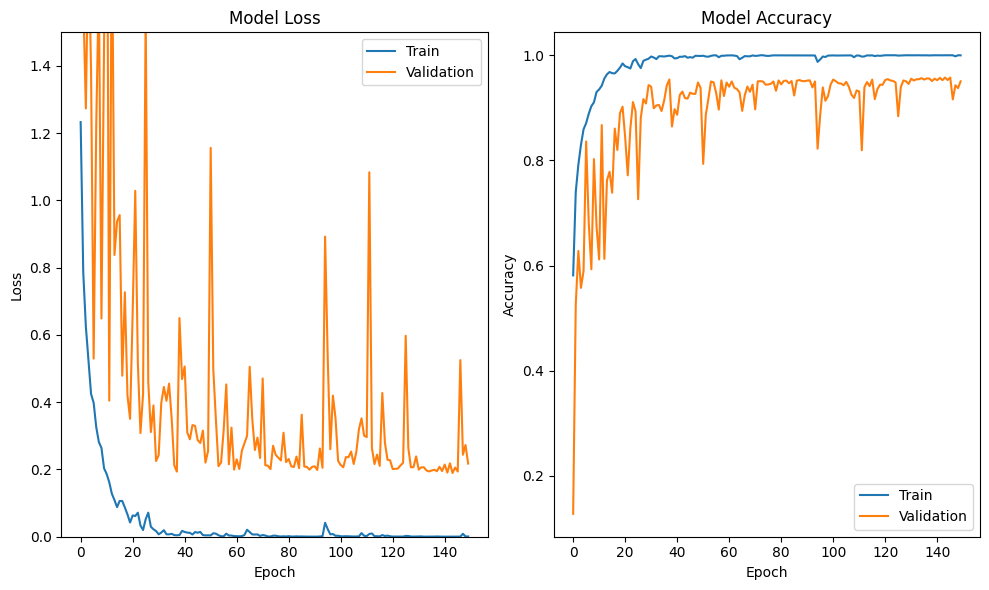

Testing Last Model: Tomato10-2Path5-LAB-m4-1.0
114/114 [==============================] - 4s 34ms/step - loss: 0.2101 - accuracy: 0.9546
loss 0.21005548536777496
acc 0.9546329379081726
Finished: Tomato10-2Path5-LAB-m4-1.0


In [6]:
for l_ratio in [1.0]:
        
        basefilename = 'Tomato10-2Path5-LAB-m4-' + str(l_ratio)
        print('Running: '+basefilename)
          
        model = two_path5_inception_v5(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=input_shape,
            two_paths=True,    
            pooling='max',
            classes=number_of_classes,
            l_ratio=l_ratio,
            ab_ratio=(1.0-l_ratio),
            max_mix_idx=4
        )
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
            metrics=['accuracy']
        )
          
        best_result_file_name = basefilename+'-best_result.hdf5'
          
        save_best = tf.keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name, 
            monitor=monitor, 
            verbose=True,
            save_best_only=True,
            save_weights_only=False, 
            mode='max',
            save_freq='epoch'
        )
          
        history = model.fit(
            train_x,
            train_y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(val_x,val_y),
            callbacks=[save_best],
            class_weight=classweight,
            workers=multiprocessing.cpu_count()
        )        
        
        history_filename = basefilename +'-History.png'
        plot_history(history_filename)
        
        print('Testing Last Model: '+basefilename)
          
        evaluated = model.evaluate(test_x,test_y)
          
        for metric, name in zip(evaluated,["loss","acc"]):
            print(name,metric)
            
#         print('Best Model Results: '+basefilename)
          
#         model = tf.keras.models.load_model(
#             best_result_file_name,
#             custom_objects={'CopyChannels': cai.layers.CopyChannels}
#         )
          
#         evaluated = model.evaluate(test_x,test_y)
          
        # cai.models.save_model(model, basefilename)
          
#         for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
#             print(name,metric)
        
        print('Finished: '+basefilename)

# Caculate Test Accuracy

In [7]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
        
        basefilename = 'Tomato10-2Path5-LAB-m4-' + str(l_ratio)
        print('Running: '+basefilename)          
        
        best_result_file_name = basefilename+'-best_result.hdf5'
            
        print('Best Model Results: '+basefilename)
          
        model = tf.keras.models.load_model(
            best_result_file_name,
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
          
        evaluated = model.evaluate(test_x,test_y)
          
        cai.models.save_model(model, basefilename)
          
        for metric, name in zip(evaluated,["loss","acc"]):
            print(name,metric)

Running: Tomato10-2Path5-LAB-m4-0.0
Best Model Results: Tomato10-2Path5-LAB-m4-0.0
114/114 [==============================] - 6s 33ms/step - loss: 0.0192 - accuracy: 0.9948
loss 0.019207773730158806
acc 0.9947758913040161
Running: Tomato10-2Path5-LAB-m4-0.25
Best Model Results: Tomato10-2Path5-LAB-m4-0.25
114/114 [==============================] - 5s 32ms/step - loss: 0.0076 - accuracy: 0.9973
loss 0.007616513408720493
acc 0.997250497341156
Running: Tomato10-2Path5-LAB-m4-0.5
Best Model Results: Tomato10-2Path5-LAB-m4-0.5
114/114 [==============================] - 5s 31ms/step - loss: 0.0055 - accuracy: 0.9978
loss 0.005490151699632406
acc 0.9978004097938538
Running: Tomato10-2Path5-LAB-m4-0.75
Best Model Results: Tomato10-2Path5-LAB-m4-0.75
114/114 [==============================] - 4s 30ms/step - loss: 0.0053 - accuracy: 0.9981
loss 0.005310785491019487
acc 0.9980753660202026
Running: Tomato10-2Path5-LAB-m4-1.0
Best Model Results: Tomato10-2Path5-LAB-m4-1.0
114/114 [=================

# Calcutale F1 and other metrics

In [6]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
    
    basefilename = 'Tomato10-2Path5-LAB-m4-' + str(l_ratio)
    
    best_result_file_name = basefilename+'-best_result.hdf5'
    
    print('Best Model Results: '+basefilename)
    
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )
    
    pred_y = model.predict(test_x)
    #         print("Predicted Shape:", pred_y.shape)
    pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
    test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
    #         print("Pred classes shape:",pred_classes_y.shape)
    #         print("Test classes shape:",test_classes_y.shape)
    report = classification_report(test_classes_y, pred_classes_y, digits=4)
    print(report)

Best Model Results: Tomato10-2Path5-LAB-m4-0.0
114/114 [==============================] - 6s 30ms/step
              precision    recall  f1-score   support

           0     0.9977    0.9977    0.9977       426
           1     0.9704    0.9850    0.9777       200
           2     0.9876    1.0000    0.9938       319
           3     0.9921    0.9843    0.9882       382
           4     1.0000    1.0000    1.0000       191
           5     0.9740    1.0000    0.9868        75
           6     1.0000    0.9944    0.9972       355
           7     0.9970    0.9911    0.9940       336
           8     0.9929    0.9893    0.9911       281
           9     1.0000    0.9991    0.9995      1072

    accuracy                         0.9948      3637
   macro avg     0.9912    0.9941    0.9926      3637
weighted avg     0.9948    0.9948    0.9948      3637

Best Model Results: Tomato10-2Path5-LAB-m4-0.25
114/114 [==============================] - 4s 28ms/step
              precision    recall 

# Confusion Matrix

Best Model Results: Tomato10-2Path5-LAB-m4-0.0
114/114 [==============================] - 6s 31ms/step


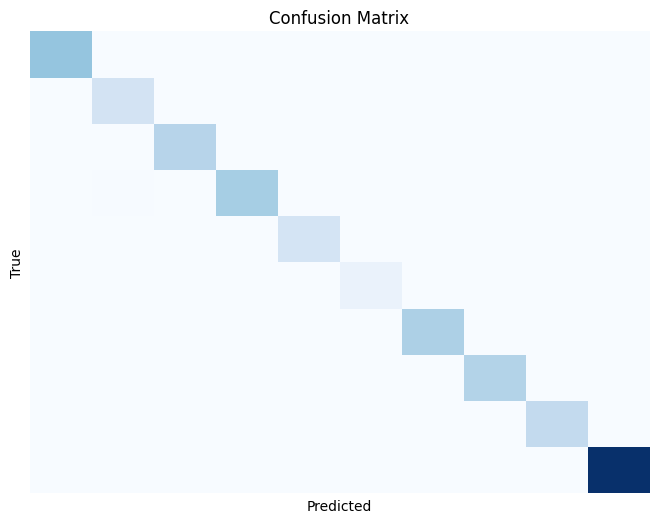

Best Model Results: Tomato10-2Path5-LAB-m4-0.25
114/114 [==============================] - 4s 29ms/step


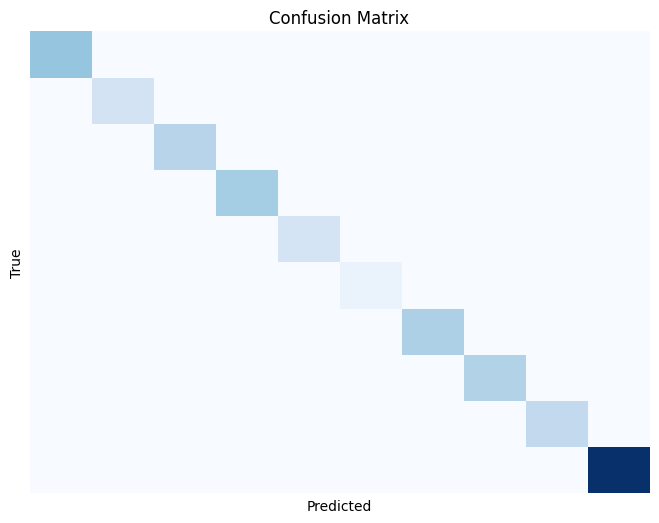

Best Model Results: Tomato10-2Path5-LAB-m4-0.5
114/114 [==============================] - 4s 28ms/step


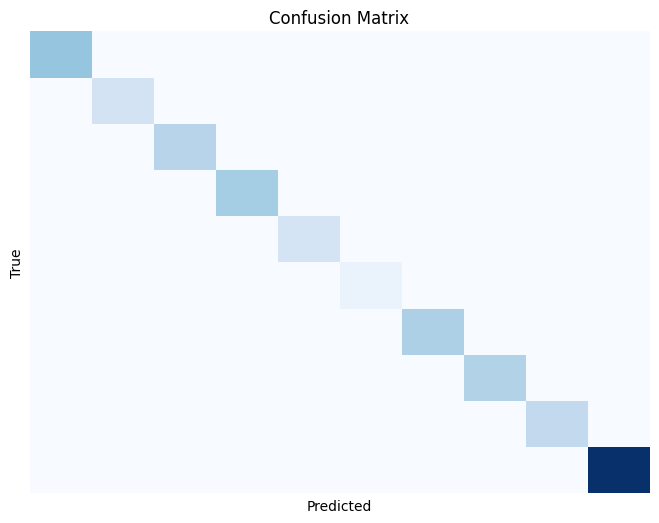

Best Model Results: Tomato10-2Path5-LAB-m4-0.75
114/114 [==============================] - 4s 27ms/step


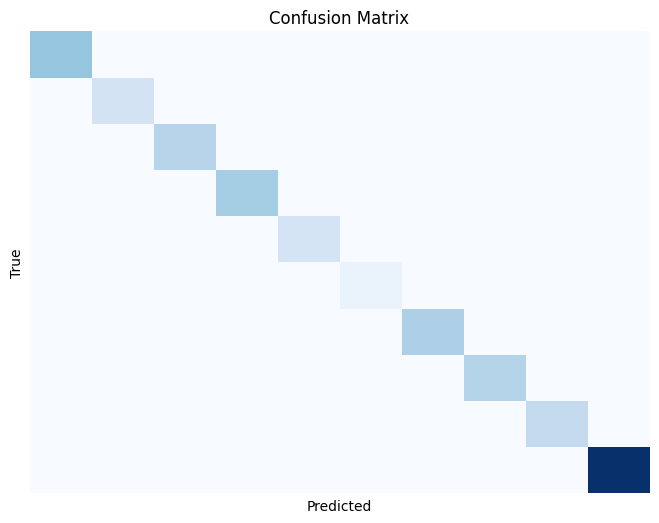

Best Model Results: Tomato10-2Path5-LAB-m4-1.0
114/114 [==============================] - 4s 26ms/step


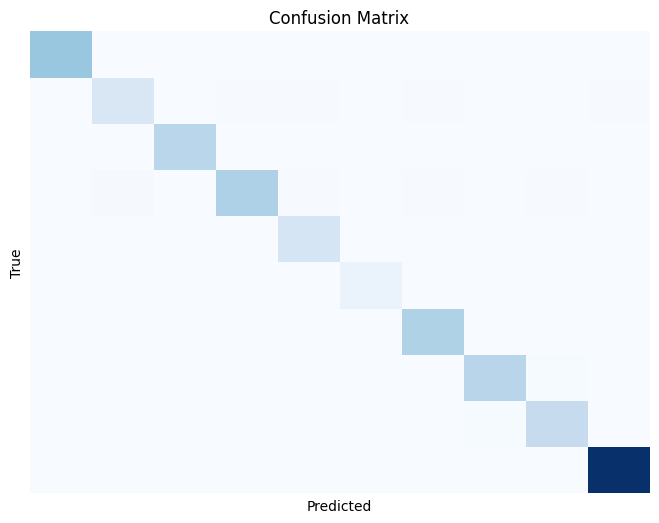

In [7]:
for l_ratio in [0.0,0.25,0.50,0.75,1.0]:
    
    basefilename = 'Tomato10-2Path5-LAB-m4-' + str(l_ratio)
     
    best_result_file_name = basefilename+'-best_result.hdf5'          

    print('Best Model Results: '+basefilename)          
    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create the confusion matrix
    cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels='', yticklabels='')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    figfilename = basefilename+'-CF.png'
    plt.savefig(figfilename, bbox_inches='tight')

    plt.show()

In [8]:
!rm results.tar.gz